In [136]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from __future__ import print_function
from sklearn import preprocessing
from time import time
# from sklearn.cross_validation import train_test_split
# from sklearn.grid_search import GridSearchCV
# from sklearn.metrics import classification_report
# from sklearn.svm import SVC
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.kernel_ridge import KernelRidge
import numpy as np
import sklearn.decomposition
import sklearn.metrics
from sklearn import gaussian_process
from sklearn import cross_validation
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from sklearn.ensemble import RandomForestClassifier

np.random.seed(1234)

#load 2015 and 2016 data into train and test data set 
horseData2015 = np.array(pd.read_excel('HorseCTrain.xlsx').values)
horseData2015 = np.vstack({tuple(row) for row in horseData2015})

horseData2016 = np.array(pd.read_excel('HorseCTest.xlsx').values)
horseData2016 = np.vstack({tuple(row) for row in horseData2016})

x_train = horseData2015[:, :-1];
y_train = horseData2015[:, -1:horseData2015[0].size];

x_test = horseData2016[:, :-1];
y_test = horseData2016[:, -1:horseData2016[0].size];

#smoooth y for both training and testing data
y_train = y_train.reshape(len(y_train),).astype(int) + (np.random.random_sample((len(y_train),))-1) + np.random.random_sample((len(y_train),))
y_test = y_test.reshape(len(y_test),).astype(int) + (np.random.random_sample((len(y_test),))-1) + np.random.random_sample((len(y_test),))

#smooth x_train for grid_search
X_train_smooth = preprocessing.scale(x_train)

param_grid = {"theta0": [0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07],
              "nugget": [0.01, 0.02, 0.03]}

clf = gaussian_process.GaussianProcess(regr="constant", corr="absolute_exponential")

# print(clf.get_params().keys())
grid_search = GridSearchCV(clf, param_grid=param_grid)
start = time()
grid_search.fit(X_train_smooth, y_train)

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))

report(grid_search.cv_results_)


GridSearchCV took 0.44 seconds for 24 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.776 (std: 0.037)
Parameters: {'theta0': 0.005, 'nugget': 0.02}

Model with rank: 2
Mean validation score: 0.774 (std: 0.033)
Parameters: {'theta0': 0.01, 'nugget': 0.03}

Model with rank: 3
Mean validation score: 0.774 (std: 0.039)
Parameters: {'theta0': 0.005, 'nugget': 0.03}



Train score R2: 0.969671715792
Test score R2: 0.833138696062


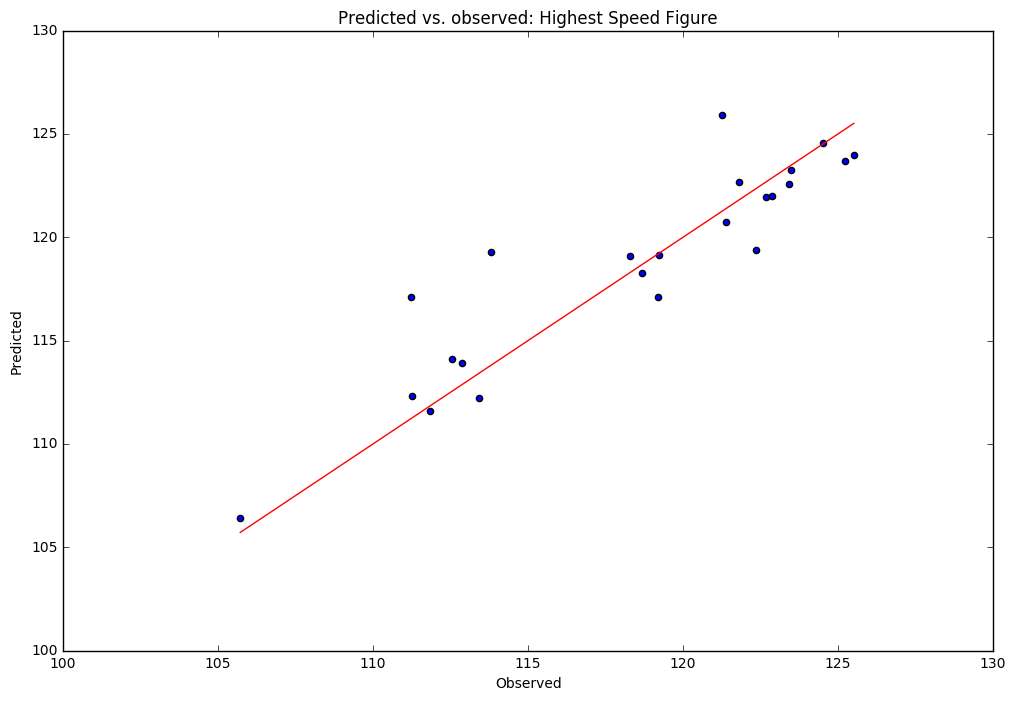

0.375391135178


In [137]:
def predictAll(theta, nugget, trainX, trainY, testX, testY, testSet, title):

    gp = gaussian_process.GaussianProcess(regr="constant", corr="absolute_exponential",theta0=theta, nugget =nugget)
    gp.fit(trainX, trainY)

    predictedY, MSE = gp.predict(testX, eval_MSE = True)
    sigma = np.sqrt(MSE)
    
    results = {}
    results['predictedY'] = predictedY
    results['sigma'] = sigma

    print ("Train score R2:", gp.score(trainX, trainY))
    print ("Test score R2:", sklearn.metrics.r2_score(testY, predictedY))

    plt.figure(figsize = (12,8))
    plt.scatter(testY, predictedY)
    plt.plot([min(testY), max(testY)], [min(testY), max(testY)], 'r')
    plt.xlim(100, 130)
    plt.ylim(100, 130)
#     plt.xlim([min(testY)[0], max(testY)[0]])
#     plt.ylim([min(testY)[0], max(testY)[0]])
    plt.title('Predicted vs. observed: ' + title)
    plt.xlabel('Observed')
    plt.ylabel('Predicted')
    plt.show()
    
    return gp, results

gp, results = predictAll(0.01, 0.025, x_train, y_train, 
                                  x_test, y_test, x_test, 'Highest Speed Figure')

def calculateError(predict, actual) :
    total =0.0
    for i in range(len(predict)):
        total += predict[i] - actual[i]
    return total/len(predict)
            
err = calculateError(results['predictedY'],y_test)
print(err)




[[ 114.]
 [ 100.]
 [ 113.]
 [ 108.]
 [ 123.]
 [ 106.]
 [ 109.]
 [ 111.]
 [ 111.]
 [  99.]
 [ 108.]
 [ 104.]
 [ 110.]]
[ 114.13648926  100.12635368  113.85712468  108.10462046  123.39803889
  105.90749842  109.38527393  110.99660459  111.93021001   99.44966425
  107.39247084  104.49805997  109.63711415]
[ 120.60171871  118.68401924  118.09417418  120.01601367  121.75428272
  119.90399535  119.0096174   116.76694182  119.83599226  117.53046553
  122.97593119  116.20972654  115.14674639]
Test score R2: -2.52897548857


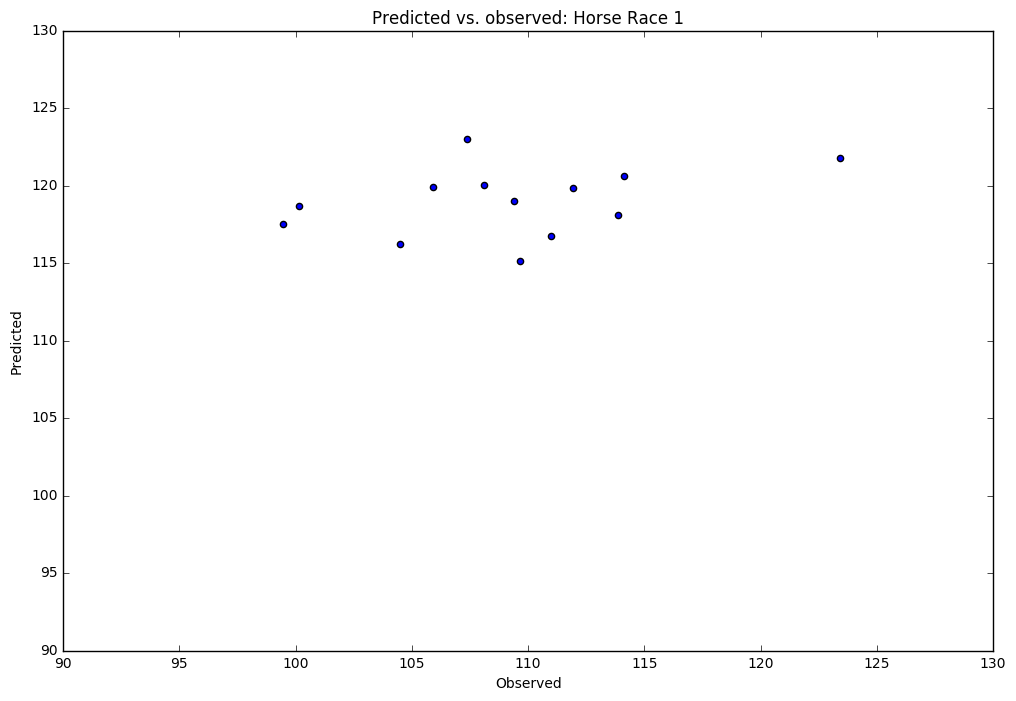

In [138]:

horseRace1 = np.array(pd.read_excel('HorseRace1.xlsx').values)
horseRace1 = np.vstack({tuple(row) for row in horseRace1})

x_hr1 = horseRace1[:, :-1];
y_hr1 = horseRace1[:, -1:horseRace1[0].size];
y_hr1 = y_hr1.reshape(len(y_hr1),).astype(int) + (np.random.random_sample((len(y_hr1),))-1) + np.random.random_sample((len(y_hr1),))

def predictTop3Horse(x_hr1 , y_hr1, title) :
    predictedY, MSE = gp.predict(x_hr1, eval_MSE = True)
    sigma = np.sqrt(MSE)

    results = {}
    results['predictedY'] = predictedY
    results['sigma'] = sigma
    
    print(predictedY)

    print ("Test score R2:", sklearn.metrics.r2_score(y_hr1, predictedY))

    plt.figure(figsize = (12,8))
    plt.scatter(y_hr1, predictedY)
    #plt.plot([min(testY), max(testY)], [min(testY), max(testY)], 'r')
    plt.xlim(90, 130)
    plt.ylim(90, 130)
    #     plt.xlim([min(testY)[0], max(testY)[0]])
    #     plt.ylim([min(testY)[0], max(testY)[0]])
    plt.title('Predicted vs. observed: ' + title)
    plt.xlabel('Observed')
    plt.ylabel('Predicted')
    plt.show()
    
predictTop3Horse(x_hr1, y_hr1, "Horse Race 1")
